# Phys 581 Winter 2019
# Assignment #4: Neural Networks
## Alexander Hickey, 10169582

Note that this notebook makes use of the Keras deep learning library for python, which is compatible only with Python 2.7-3.6.

In [31]:
#Must be running Python 3.6 or lower!
import sys
sys.version

'3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]'

In [32]:
#Import useful libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.integrate
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.backend import clear_session
%matplotlib inline

### Introduction

Inspired by biological neural networks, a method of machine learning known as deep learning has revolutionized the way that scientists model complex systems. In general, a neural network is a collection of connected nodes (or *neurons*) that can transmit data through their connections (or *edges*). Typically, the neurons are oraganized into layers, each of which can perform different kings of transformations on their inputs. Additionally, each of the edges are assigned a weight that increases or decreases the strength of a signal at an edge, and these weights are adjusted in the learning process using a set of training data. The term *deep* neural network refers to a neural network with more than one hidden layer (see Figure below).

![Deep neural network](http://neuralnetworksanddeeplearning.com/images/tikz41.png)

(Image source: http://neuralnetworksanddeeplearning.com/chap6.html)


Recently, there has been great interest in the use of machine learning to predict solutions of physical problems, such as the solutions of a non-linear system of differential equations. In this notebook, we will explore the implementation of machine learning to predict the time evolution of the Lorenz system, which is notable for producing chaotic solutions under certain parameter ranges. The Lorenz equations are:

\begin{align*}
\frac{dx}{dt} &= \sigma(y-x) \\
\frac{dy}{dt} &= x(\rho-z)-y \\
\frac{dz}{dt} &= xy-\beta z
\end{align*}

For the choice of parameters $(\sigma,\beta,\rho) = (10,8/3,58)$, it is known that the solution is a "butterfly" like strange attractor that exhibits deterministic chaos. The goal of this work will be to construct and train a neural network that takes a solution set of the Lorenz equations over some time interval $[0,t]$, and predicts the solution set over some shifted time interval $[\Delta t,t+ \Delta t]$. This will be done through the use of Keras, a deep learning library for Python. The accuracy of the neural network predictions will be examined under various time shifts and network topologies.

We begin by generating a 3-d time series solution for the Lorenz equations with the parameters selected to produce "butterfly" strange attractors.

In [29]:
def dfunc(state, t0, sigma=10.0, beta=8/3.0, rho=58.0):
    '''
    This returns the time derivative of the coordinates,
    defined by the 3D Lorenz system:
    dx/dt = sigma*(y-x)
    dy/dt = x*(rho-z)-y
    dz/dt = x*y-beta*z
    
    Args:
        state: array of length 3, coordinates at time t0
        t0: Time
        sigma, beta, rho: Lorentz system parameters
        
    Return:
        d/dt state: array, Time derivative of coordinates
    
    '''
    
    #Unpack state vector
    x, y, z = state
    
    return np.array([ sigma*(y-x), x*(rho-z)-y, x*y-beta*z])

#Define time interval of interest
t0, tf, tstep = 0.0, 20.0, 9999
tvals = np.linspace(t0, tf, tstep)

#Set initial state set to [1,1,1]
xyz_0 = np.ones(3)

#Integrate Lorenz system over time interval
xyz = scipy.integrate.odeint( dfunc, xyz_0, tvals )

The solution can be visualized by plotting each of the spatial coordinates as a time series

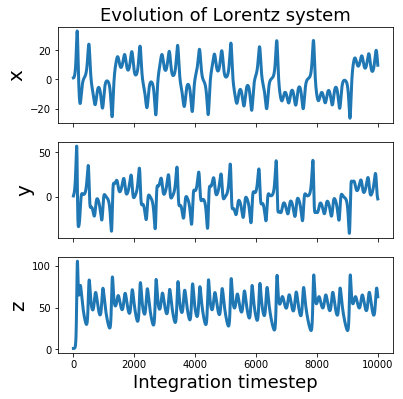

In [30]:
#Plot x,y,z components of Lorenz system from t=0 to t=20
fig, ax = plt.subplots(3, sharex=True, figsize=(6,6))

ax[0].plot( xyz[:,0], lw=3 )
ax[0].set_ylabel('x',fontsize=20)
ax[1].plot( xyz[:,1], lw=3 )
ax[1].set_ylabel('y',fontsize=20)
ax[2].plot( xyz[:,2], lw=3 )
ax[2].set_ylabel('z',fontsize=20)

ax[0].set_title('Evolution of Lorenz system',fontsize=18) 
ax[-1].set_xlabel('Integration timestep',fontsize=18)

plt.show()

As expected, the solution turns out to look quite complicated. To better observe the "butterfly" like behaviour of the tragectory, we can view this as a 3D projection.

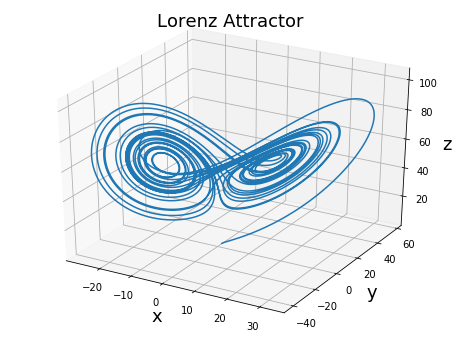

In [5]:
#Plot 3D trajectory of Lorenz system
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('x',fontsize=18)
ax.set_ylabel('y',fontsize=18)
ax.set_zlabel('z',fontsize=18)
ax.set_title('Lorenz Attractor',fontsize=18)

ax.plot(*xyz.T)
plt.show()

### Deep learning

###### Build a simple model to use current state at time `T` to predict future state at time `T + dt`

We begin by defining the model in the Keras framework. In particular, this means defining the particular topology of the deep learning network. To start, we fix the random seed in both the numpy and tensorflow libraries. This is generally a good idea when testing properties of a neural network, as it makes the otherwise stochastic construction of the network weights to be reproducible. As is standard within the Keras library, the network is taken to be dense, meaning that each node of one layer is connected to every other node in the next. The model is compiled using the mean-squared error as a loss function and the "adam" optimizer.

In [6]:
#Fix random seed
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

#Create model
model = Sequential()
model.add(Dense(8, input_dim=3, activation='relu'))
model.add(Dense(11, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

#Compile model
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 32        
_________________________________________________________________
dense_2 (Dense)              (None, 11)                99        
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 21        
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________


Next, we run through $999$ epochs of the traning routine, by using the time series data for the interval $[0,L]$ as the input, and the time series data for the shifted interval $[\Delta t, L+\Delta t]$ as the desired output. At each epoch, the mean-squared error is computed for both the training data and a so-called validation interval, where the data for the interval $[vs,vs+L]$ is used as input. In this case, we have chosen $\Delta t = 99$., $L=900$, and $vs=5000$.

In [7]:
stack = []
ndt = 99  #future prediction time shift
L = 900 #Length of timestep interval
vs = 5000 #Starting point of validation interval
ne = 999 #Number of epochs

#Model will attempt to shift data set by a timestep of ndt
#i.e. use points [0:900] to predict points [99:999]
for epoch in range(ne):
    
    # take one step
    history = model.fit(xyz[:L],xyz[ndt:L+ndt], epochs=1, batch_size=100, verbose=0) # initial_epoch=epoch

    # calculate prediction quality for training data
    rms_training = np.sqrt( np.mean( (xyz[ndt:L+ndt,:] - model.predict(xyz[:L]) )**2 ) )
    
    # calculate prediction quality for distant future data
    rms_validate = np.sqrt( np.mean( (xyz[vs+ndt:vs+L+ndt,:] - model.predict(xyz[vs:vs+L]) )**2 ) )   
    
    #Record root mean square error for each epoch
    stack.append([rms_training, rms_validate])
    
stack = np.array(stack)

Next we plot the mean-squared error over the training process.

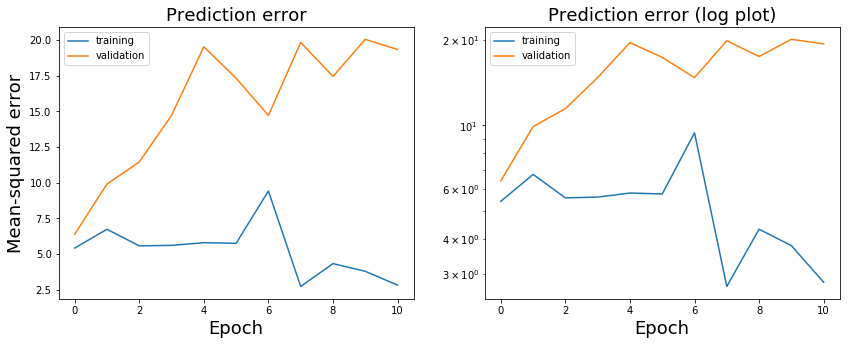

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

plt.sca(axes[0])
plt.plot( stack[:,0], label='training' )
plt.plot( stack[:,1], label='validation')
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Mean-squared error',fontsize=18)
plt.title('Prediction error',fontsize=18)
plt.legend(loc=0)

plt.sca(axes[1])
plt.plot( stack[:,0], label='training' )
plt.plot( stack[:,1], label='validation')
plt.xlabel('Epoch',fontsize=18)
plt.title('Prediction error (log plot)',fontsize=18)

plt.legend(loc=0)
plt.yscale('log')

We see that the discrepency between the model data and the training data decreases quite rapidly, with a few small-plateaus.  The validation fit also improves throughout the training process, and at times is actually better than the training results.  They eventually both appear to converge, to some finite value, with minor fluctuations in the error appearing at later epochs. We can see how the actual tragectories appear by plotting the time series prediction.

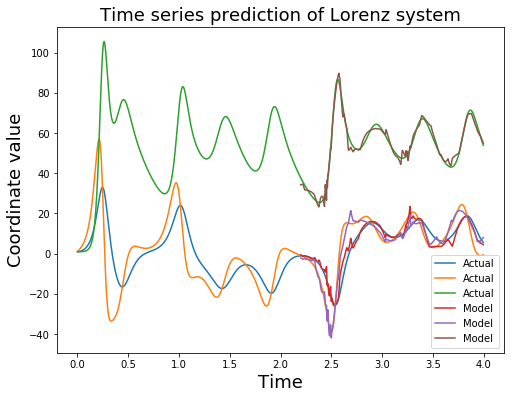

In [58]:
plt.figure(figsize=(8,6))
plt.plot(tvals[:L+ndt], xyz[:L+ndt,:],label='Actual')
plt.plot( tvals[ndt:L+ndt], model.predict( xyz[:L]),label='Model' )
plt.xlabel('Time',fontsize=18)
plt.ylabel('Coordinate value',fontsize=18)
plt.title('Time series prediction of Lorenz system',fontsize=18)

plt.legend(loc=0)
plt.show()

Qualitatively, the fit to the training data appears to be quite good. Let's see if this holds up for the entire data set:

ValueError: x and y must have same first dimension, but have shapes (8900,) and (9900, 3)

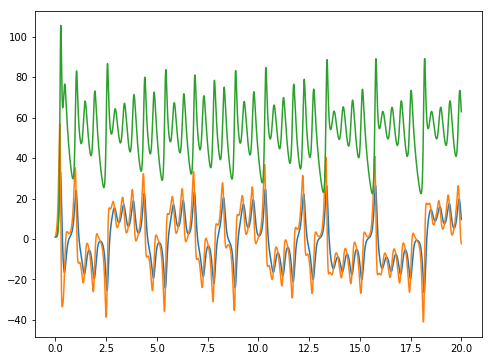

In [59]:
#Define tail end of time interval
vt = 9000

plt.figure(figsize=(8,6))
plt.plot(tvals[:vt+L+ndt], xyz[:vt+L+ndt,:],label='Actual')
plt.plot( tvals[ndt:vt+L+ndt], model.predict(xyz[:vt+L]),label='Predicted' )
plt.xlabel('Time',fontsize=18)
plt.ylabel('Coordinate value',fontsize=18)
plt.title('Time series prediction of Lorenz system',fontsize=18)

plt.legend(loc=0)
plt.show()

As we see, the model seems to match the data set quite well on a global scale. Finally, let's look at how the model holds up near the tail end of the validation region:

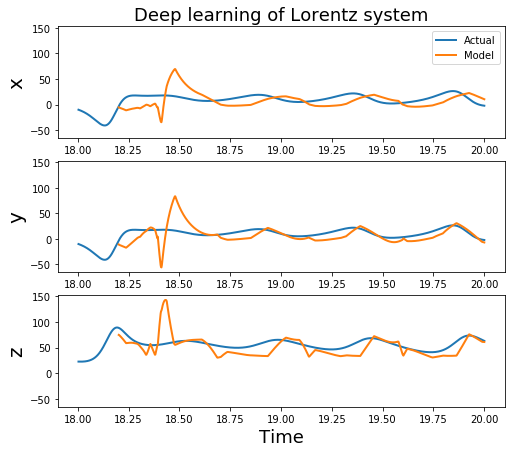

In [12]:
fig, ax = plt.subplots(3, sharey=True, figsize=(8,7))

ax[0].plot(tvals[vt:vt+L+ndt], xyz[vt:vt+L+ndt:,1], lw=2,label='Actual')
ax[0].plot(tvals[vt+ndt:vt+L+ndt], model.predict(xyz[vt:vt+L,:]).T[0], lw=2,label='Model')
ax[0].set_ylabel('x',fontsize=20)
    
ax[1].plot(tvals[vt:vt+L+ndt], xyz[vt:vt+L+ndt:,1], lw=2 )
ax[1].plot(tvals[vt+ndt:vt+L+ndt], model.predict(xyz[vt:vt+L,:]).T[1], lw=2)
ax[1].set_ylabel('y',fontsize=20)

ax[2].plot(tvals[vt:vt+L+ndt], xyz[vt:vt+L+ndt:,2], lw=2)
ax[2].plot(tvals[vt+ndt:vt+L+ndt], model.predict(xyz[vt:vt+L,:]).T[2], lw=2 )
ax[2].set_ylabel('z',fontsize=20)

ax[0].set_title('Deep learning of Lorentz system',fontsize=18) 
ax[-1].set_xlabel('Time',fontsize=18)

ax[0].legend(loc=0)
plt.show()

The neural network model appears to match the data quite well in this region as well (i.e. if you squint a little), aside from various minor fluctuations.

## Tasks

#### The validation curve appears to fluctuate more than the training curve at later epochs.  Discuss why this might be.


We see that at later epochs in the training routine, the mean squared error tends to asymptote at some nonzero value, and fluctuations become more pronounced. The fact that fluctuations begin to appear at later epochs suggests that these fluctuations are a remenant of the chaotic nature of the Lorenz system. While the trajectory of the Lorentz system through phase space is deterministic in nature, the long term evolution of the system is extraordinarily sensitive to initial conditions. Even a small discrepency between initial conditions (i.e. on the order of double precision) can lead to considerably different dynamics. It follows that, while machine learning will likely be able to predict the global, quasi-periodic behaviour of a strange attractor, it will always be limited by machine precision in predicting deterministic chaos.

#### Tidy up code (eg. factor out magic numbers like 9000:9900) and make sure it is correct.

See the code following the introduction.

#### How does prediction quality decrease for larger `ndt` ie. further into the future?

In [13]:
def create_model(nodes=[8,11,6]):
    
    #Create model
    model = Sequential()
    
    #Define input layer
    model.add(Dense(nodes[0], input_dim=3, activation='relu'))
    
    #Define "deep" layers
    for n in nodes[1:]:
        
        model.add(Dense(n, activation='relu'))
    
    #Define output layer
    model.add(Dense(3, activation='linear')) #sigmoid'))

    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

def train_model(model,ndt,xyz,L=900,epochs=999):
    
    history = model.fit(xyz[:L],xyz[ndt:L+ndt], epochs=epochs, batch_size=100, verbose=0)
    
    return model

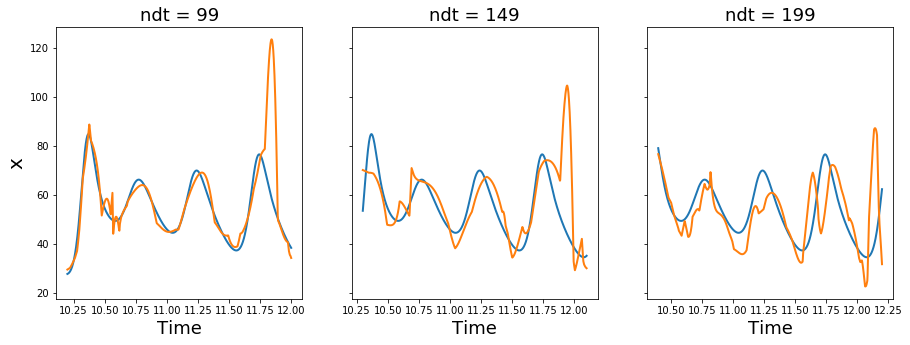

In [14]:
L = 900 #Length of timestep interval
vs = 5000 #Starting point of validation interval
ker = train_model(create_model(),ndt,xyz)

fig, ax = plt.subplots(1,3, sharey=True, figsize=(15,5))
ax[0].set_ylabel('x',fontsize=20)
ndtl = [99,149,199]

for j in range(len(ndtl)):
    
    ker = train_model(create_model(),ndtl[j],xyz)
    ax[j].plot(tvals[vs+ndtl[j]:vs+L+ndtl[j]], xyz[vs+ndtl[j]:vs+L+ndtl[j]:,2], lw=2,label='Actual')
    ax[j].plot(tvals[vs+ndtl[j]:vs+L+ndtl[j]], ker.predict(xyz[vs:vs+L,:]).T[2], lw=2 ,label='Model')
    ax[j].set_xlabel('Time',fontsize=18)
    ax[j].set_title('ndt = '+str(ndtl[j]),fontsize=18)

In [24]:
ndt_list = np.arange(99,1100,100)
stack = []

for ndt in ndt_list:
    
    print(ndt)
    
    clear_session()
    
    ker = train_model(create_model(),ndt,xyz,epochs=999)
    
    rms_training = np.sqrt( np.mean( (xyz[ndt:L+ndt,:] - ker.predict(xyz[:L]) )**2 ) )
    
    rms_validate = np.sqrt( np.mean( (xyz[vs+ndt:vs+L+ndt,:] - ker.predict(xyz[vs:vs+L]) )**2 ) )   
    
    stack.append([rms_training, rms_validate])
    
stack = np.array(stack)

99
199
299
399
499
599
699
799
899
999
1099


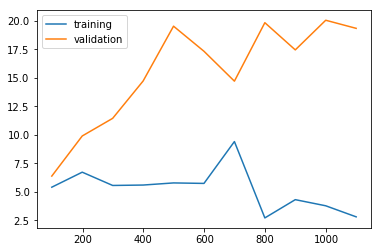

In [25]:
plt.plot(ndt_list, stack[:,0], label='training' )
plt.plot(ndt_list, stack[:,1], label='validation')
plt.legend(loc=0)

plt.show()

#### Explore changing hyper parameters (the number of layers, nodes per layer etc.) to improve prediction quality

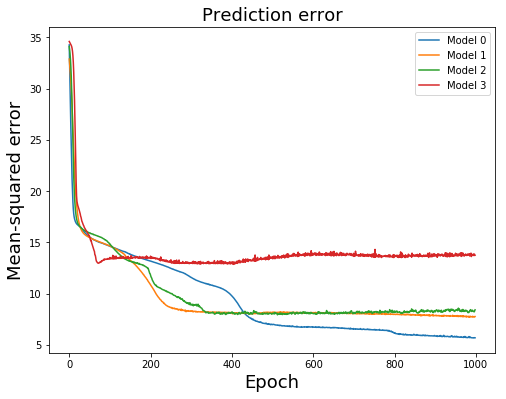

In [62]:
num_layers = [[5,8,5],[5,8,8,5],[5,8,8,8,5],[5,8,8,8,8,5]]
ndt = 99 
L, vs, ne = 900, 5000, 999 

plt.figure(figsize=(8,6))

for j in range(len(num_layers)):
    
    stack = []
    model = create_model(nodes = num_layers[j])
    
    for epoch in range(ne):
    
        # take one step
        model = train_model(model,ndt,xyz,epochs=1)

        # calculate prediction quality for distant future data
        rms_validate = np.sqrt( np.mean( (xyz[vs+ndt:vs+L+ndt,:] - model.predict(xyz[vs:vs+L]) )**2 ) )   
    
        #Record root mean square error for each epoch
        stack.append(rms_validate)
    
    plt.plot(stack,label='Model '+str(j+1))

plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Mean-squared error',fontsize=18)
plt.title('Prediction error',fontsize=18)
plt.legend(loc=0)
plt.show()

In [18]:
num_nodes = [[5,8,5],[8,11,6],[11,15,9],[13,19,11]]

ndt = 99 
L, vs, ne = 900, 5000, 999 

plt.figure(figsize=(8,6))

for j in range(len(num_layers)):
    
    stack = []
    model = create_model(nodes = num_layers[j])
    
    for epoch in range(ne):
    
        # take one step
        model = train_model(model,ndt,xyz,epochs=1)

        # calculate prediction quality for distant future data
        rms_validate = np.sqrt( np.mean( (xyz[vs+ndt:vs+L+ndt,:] - model.predict(xyz[vs:vs+L]) )**2 ) )   
    
        #Record root mean square error for each epoch
        stack.append(rms_validate)
    
    plt.plot(stack,label='Model '+str(j))

plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Mean-squared error',fontsize=18)
plt.title('Prediction error',fontsize=18)
plt.legend(loc=0)

### Conclusion

In this notebook, we examined...